# Titanic

### Dataset

Task: predict survival of Titanic passengers

Size: 891 in train set, 418 in test set

Given features:
- Ticket class
- Name
- Sex
- Age
- \# of siblings/spouses on board
- \# of parents/children on board
- Ticket number
- Fare
- Cabin
- Embarkation location

## Data Exploration

In [1]:
from pprint import pprint
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
sns.set(style='whitegrid')

In [2]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
targets = train_data['Survived']

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data['Died'] = 1 - train_data['Survived']

### Missing data

In [6]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Died             0
dtype: int64

In [7]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Univariate exploration

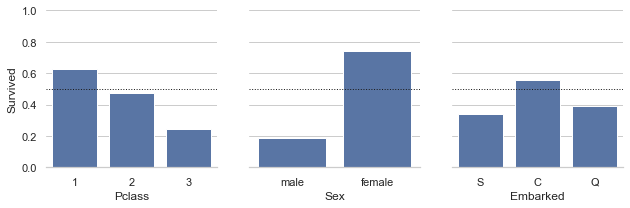

In [8]:
p = sns.PairGrid(data=train_data,
                 y_vars='Survived',
                 x_vars=['Pclass', 'Sex', 'Embarked'],
                 height=3)
p.set(ylim=(0, 1))
p.map(sns.barplot, ci=None)
for ax in p.axes.flatten():
    ax.axhline(y=0.5, ls=':', color='k', lw=1)
sns.despine(fig=p.fig, left=True)

(0, 1)

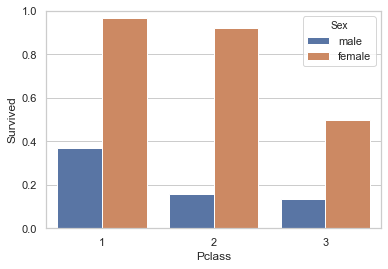

In [9]:
sns.barplot(data=train_data, x='Pclass', y='Survived', hue='Sex', ci=None)
plt.ylim(0, 1)

(0, 1)

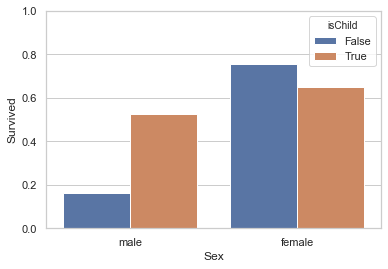

In [10]:
train_data['isChild'] = train_data['Age'].map(lambda age: age < 16)
sns.barplot(data=train_data, x='Sex', hue='isChild', ci=None, y='Survived')
plt.ylim(0, 1)

C:\Users\lim.yaoc\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


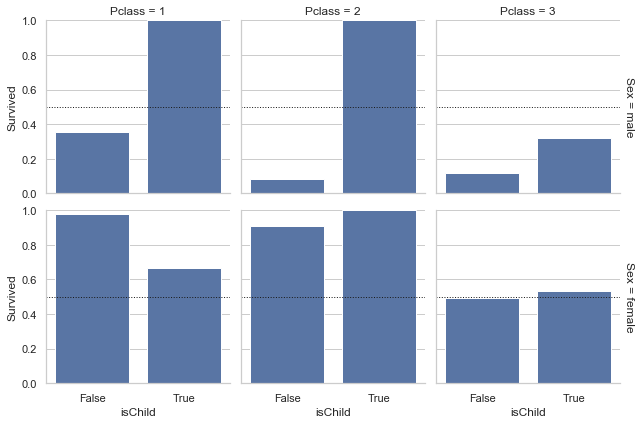

In [11]:
p = sns.FacetGrid(data=train_data, row='Sex', col='Pclass', col_order=[1, 2, 3], margin_titles=True)
p.map(sns.barplot, 'isChild', 'Survived', ci=None)
for ax in p.axes.flatten():
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, ls=':', lw=1, color='k')

In [12]:
print(train_data.groupby(['Sex', 'Pclass', 'isChild'])['PassengerId'].count())

Sex     Pclass  isChild
female  1       False       91
                True         3
        2       False       66
                True        10
        3       False      114
                True        30
male    1       False      119
                True         3
        2       False       99
                True         9
        3       False      319
                True        28
Name: PassengerId, dtype: int64


#### Fare

Low fares have a lower chance of survival

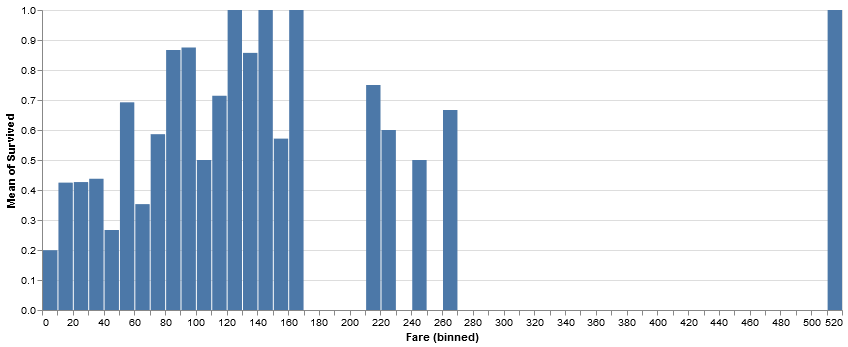

In [13]:
alt.Chart(train_data).mark_bar().encode(
    alt.X('Fare', bin=alt.Bin(step=10)),
    y='mean(Survived)'
).properties(width=800)

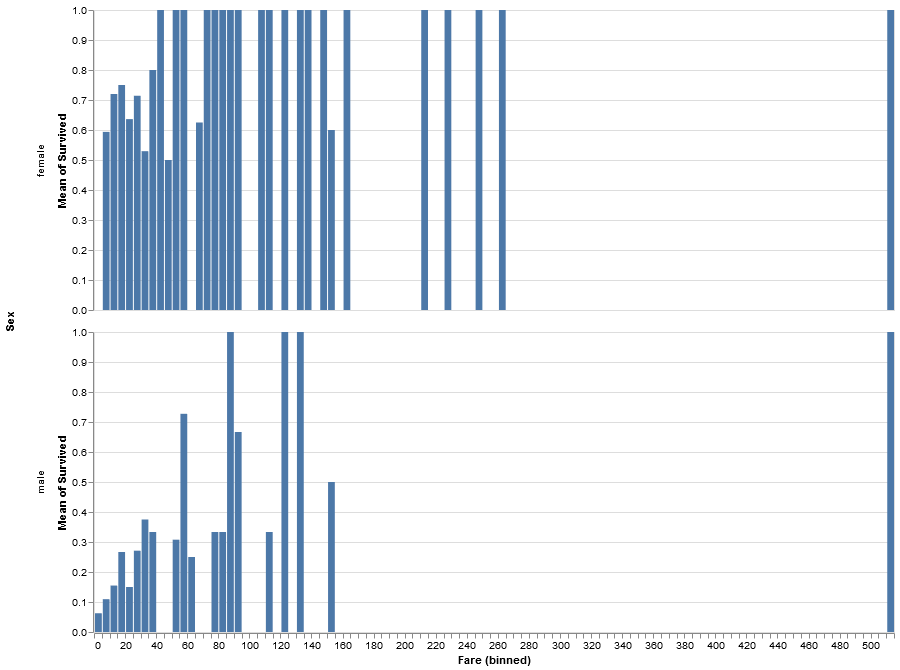

In [14]:
alt.Chart(train_data).mark_bar().encode(
    alt.X('Fare', bin=alt.Bin(step=5)),
    y='mean(Survived)'
).properties(
    width=800
).facet(
    row='Sex:N'
)

#### Age

Lower age tends to mean higher chance of survival

Male + female

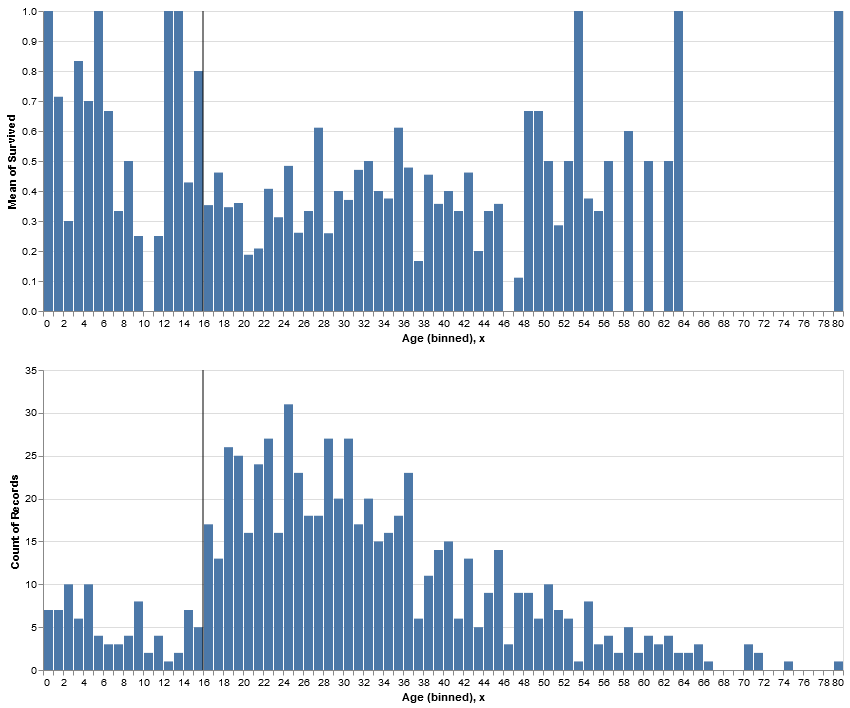

In [15]:
base = alt.Chart(train_data)

surv = base.mark_bar().encode(
    alt.X('Age', bin=alt.Bin(step=1)),
    y='mean(Survived)'
)
counts = base.mark_bar().encode(
    alt.X('Age', bin=alt.Bin(step=1)),
    y='count()'
)
rule = alt.Chart(pd.DataFrame({'x': [16]})).mark_rule().encode(
    x='x:Q'
)

alt.vconcat((surv + rule).properties(width=800), (counts + rule).properties(width=800))

Male only (from 14-16, rate of survival drops)

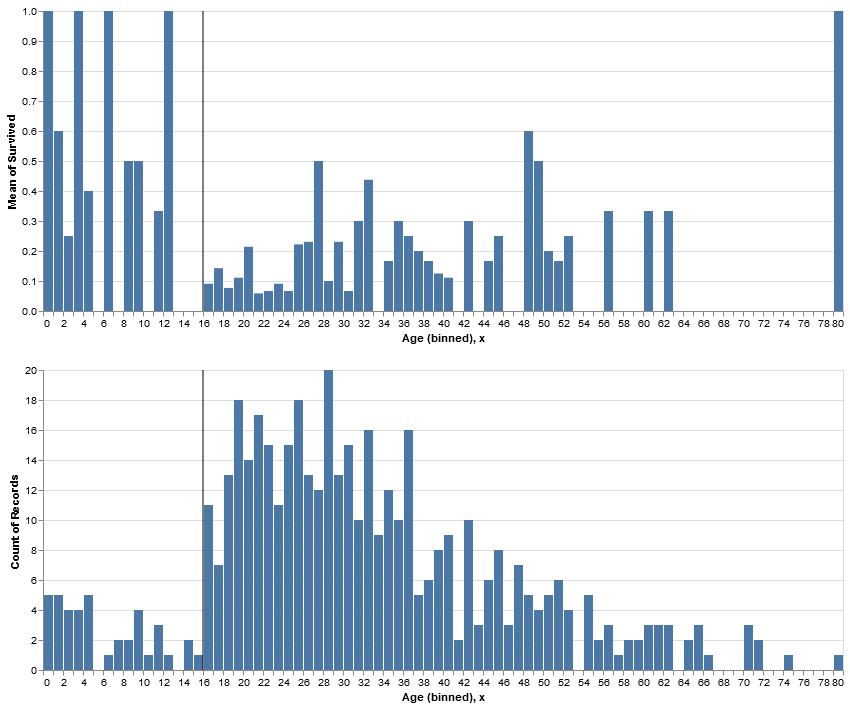

In [16]:
base = alt.Chart(train_data[train_data['Sex'] == 'male'])

surv = base.mark_bar().encode(
    alt.X('Age', bin=alt.Bin(step=1)),
    y='mean(Survived)'
)

rule = alt.Chart(pd.DataFrame({'x': [16]})).mark_rule().encode(
    x='x:Q'
)

counts = base.mark_bar().encode(
    alt.X('Age', bin=alt.Bin(step=1)),
    y='count()'
)

alt.vconcat((surv + rule).properties(width=800), (counts + rule).properties(width=800))

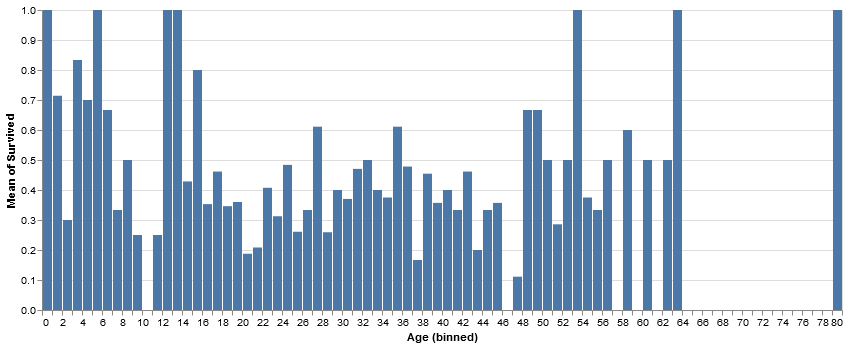

In [17]:
alt.Chart(train_data).mark_bar().encode(
    alt.X('Age', bin=alt.Bin(step=1)),
    y='mean(Survived)'
).properties(width=800)

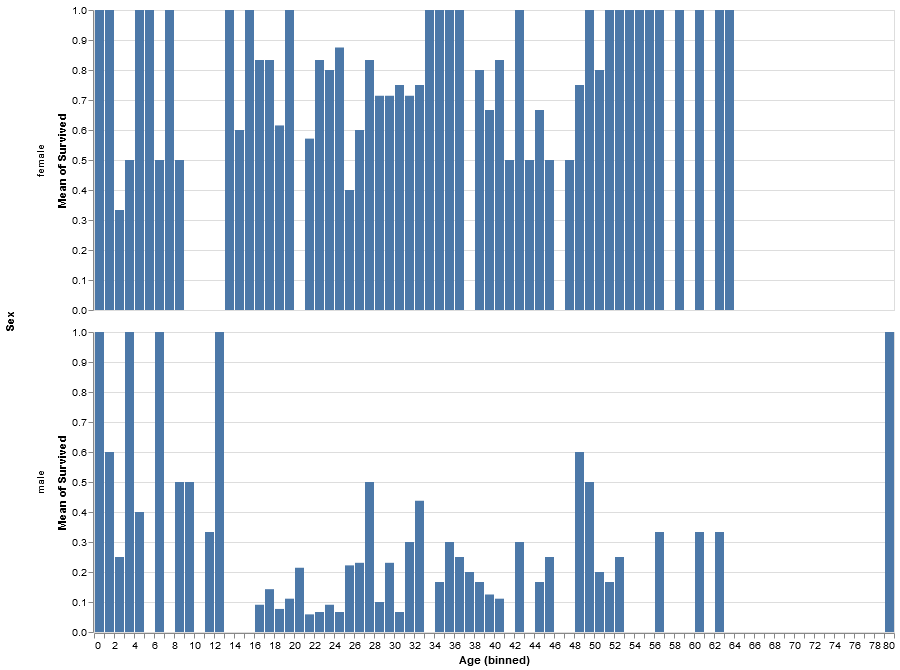

In [18]:
alt.Chart(train_data).mark_bar().encode(
    alt.X('Age', bin=alt.Bin(step=1)),
    y='mean(Survived)'
).properties(
    width=800
).facet(
    row='Sex:N'
)

#### Title

The title of each passenger (Mr., Mrs., Doctor. etc.)

In [19]:
def get_title(name):
    return name.split(',')[1].split('.')[0].strip()

def get_category(title):
    return title_mapping.get(title, 'Other')

title_mapping = {
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Ms': 'Miss',
    'Mlle': 'Miss',
    'Master': 'Master',
    'Mme': 'Mrs',
    'Major': 'Officer',
    'Col': 'Officer',
    'Capt': 'Officer',
    'Don': 'Royalty',
    'Lady': 'Royalty',
    'Sir': 'Royalty',
    'the Countess': 'Royalty',
    'Jonkheer': 'Royalty',
    'Rev': 'Other',
    'Dr': 'Other',
    #'Rev': 'Officer',
    #'Dr': 'Officer',
    #'Dona': 'Royalty',  # only appears in test set
}

In [20]:
train_data['Category'] = train_data['Name'].map(lambda n: get_category(get_title(n)))

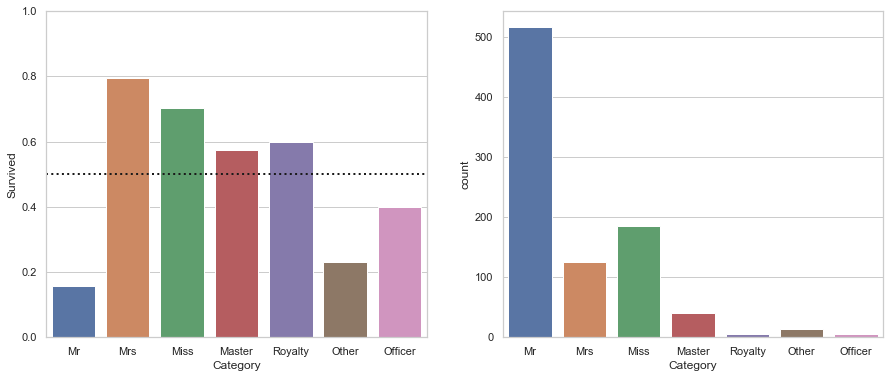

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 6))
sns.barplot('Category', 'Survived', data=train_data, ci=None, ax=ax1)
ax1.axhline(y=0.5, color='k', ls=':', lw=2)
ax1.set_ylim(0, 1)
_ = sns.countplot('Category', data=train_data, ax=ax2)

#### Cabins and Decks

Handling missing data for cabin: We just put 'unknown'

The cabins have the format &lt;Letter&gt; &lt;Number&gt;. The letter indicates which deck the cabin is on (A is the highest deck, G is the lowest), so this might be a predictive feature for survival.

In [22]:
train_data['Cabin'].fillna('U', inplace=True)
train_data['Deck'] = train_data['Cabin'].map(lambda c: c[0])

In [23]:
for deck in sorted(train_data['Deck'].unique()):
    subset = train_data[train_data['Deck'] == deck]
    frac = subset.sum()['Survived'] / len(subset)
    print(f'{deck}\t{len(subset)}\t{frac:.2f}')

A	15	0.47
B	47	0.74
C	59	0.59
D	33	0.76
E	32	0.75
F	13	0.62
G	4	0.50
T	1	0.00
U	687	0.30


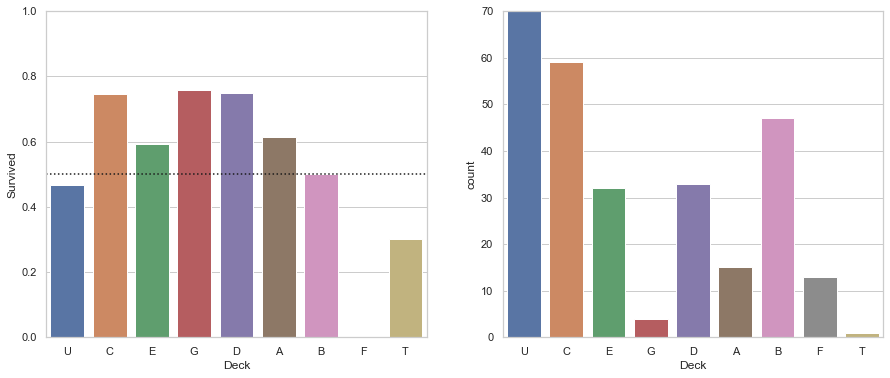

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 6))
sns.barplot('Deck', 'Survived', data=train_data, ci=None, order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], ax=ax1)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, ls=':', color='k')
ax2.set_ylim(0, 70)
_ = sns.countplot('Deck', data=train_data, ax=ax2)

#### Family size

In [25]:
def family_size(row):
    return row['SibSp'] + row['Parch']

In [26]:
train_data['FamilySize'] = train_data.apply(family_size, axis=1)

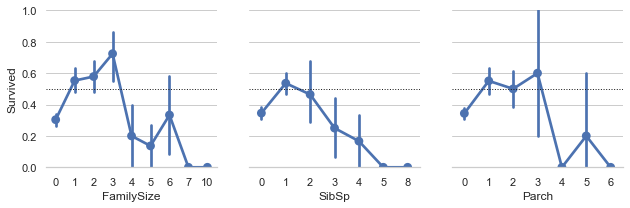

In [27]:
p = sns.PairGrid(data=train_data,
                 y_vars='Survived',
                 x_vars=['FamilySize', 'SibSp', 'Parch'],
                 height=3)
p.set(ylim=(0, 1))
p.map(sns.pointplot, scale=1)
for ax in p.axes.flatten():
    ax.axhline(y=0.5, ls=':', lw=1, color='k')
sns.despine(fig=p.fig, left=True)

## Features

Features implemented:
- Imputation of missing values
- Title + Category
- Family features
- Ticket features
- Cabin features
- Combination features

### Title + Category

In [28]:
def get_title(name):
    return name.split(',')[1].split('.')[0].strip()

def get_category(title):
    return title_mapping.get(title, 'Other')

title_mapping = {
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Ms': 'Miss',
    'Mlle': 'Miss',
    'Master': 'Master',
    'Mme': 'Mrs',
    'Major': 'Officer',
    'Col': 'Officer',
    'Capt': 'Officer',
    'Don': 'Royalty',
    'Lady': 'Royalty',
    'Sir': 'Royalty',
    'the Countess': 'Royalty',
    'Jonkheer': 'Royalty',
    'Rev': 'Other',
    'Dr': 'Other',
    #'Rev': 'Officer',
    #'Dr': 'Officer',
    #'Dona': 'Royalty',  # only appears in test set
}

### Family features
- size of family
- Categorize into big, small, and non-families (since families > 4 seem to have higher rates of death)
- whether someone from the family survived

Approach for last feature:
1. From training set, get list of last names. Assume those with the same last name are from the same family.
2. Names that have no family (or SibSp + Parch == 0) are set to 'U'. 
3. Names with family: those with family who survived (in the training set) get 'Y', 
   those without get 'N'.

In [29]:
def have_family(row):
    if row['SibSp'] > 0 or row['Parch'] > 0:
        return 1
    else:
        return 0

def family_size(row):
    return row['SibSp'] + row['Parch']

def family_size_cat(row):
    fam_size = family_size(row)
    if fam_size == 0:
        return 'Single'
    elif fam_size < 4:
        return 'Small'
    else:
        return 'Big'
    
def last_name(name):
    return name.split(',')[0].strip()

def get_survived_names(data):
    return set(data.loc[data['Survived'] == 1]['Name'].map(last_name))

def get_family_status(data):
    survived_names = get_survived_names(data)
    all_names = set(data['Name'].apply(last_name))
    status = {
        n: True for n in survived_names
    }
    status.update({
        n: False for n in (all_names - survived_names)
    })
    return status

def get_family_survived(row, family_status):
    l_name = last_name(row['Name'])
    
    if (row['SibSp'] == 0 and row['Parch'] == 0) or l_name not in family_status:
        return 'U'
    elif family_status[l_name]:
        return 'Y'
    else:
        return 'N'

# also join family name with family size??

def add_family_features(data):
    data['FamilySize'] = data.apply(family_size, axis=1)
    data['HaveFamily'] = data.apply(have_family, axis=1)
    data['FamilyCategory'] = data.apply(family_size_cat, axis=1)
    
    train_data, _ = split_data(data)

    family_status = get_family_status(train_data)
    data['FamilySurvived'] = data.apply(lambda row: get_family_survived(row, family_status), axis=1)

    return data

### Ticket features

- \# of digits in the ticket number
- The first letter of the ticket (or whether the ticket only had numbers)
- The prefix of the ticket (i.e. the part before the number)
- Whether someone on the ticket survived (different from family, since some families had nannies, or had unrelated people on the same ticket)
  - Only have this feature for tickets with >1 person. Otherwise put 'U' (unknown)

In [30]:
prefixes = train_data['Ticket'].map(lambda tick: tick.rsplit(maxsplit=1)[0] if not tick.isdigit() else 'DIGIT')
pprint(prefixes.value_counts())

DIGIT          661
PC              60
C.A.            27
STON/O 2.       12
A/5             10
W./C.            9
CA.              8
SOTON/O.Q.       8
SOTON/OQ         7
A/5.             7
STON/O2.         6
CA               6
C                5
SC/PARIS         5
S.O.C.           5
F.C.C.           5
LINE             4
SC/Paris         4
A/4.             3
PP               3
S.O./P.P.        3
A/4              3
SC/AH            2
S.C./PARIS       2
A./5.            2
P/PP             2
A.5.             2
WE/P             2
SOTON/O2         2
S.C./A.4.        1
C.A./SOTON       1
SCO/W            1
F.C.             1
A/S              1
A4.              1
SC               1
SW/PP            1
SC/AH Basle      1
SO/C             1
S.W./PP          1
Fa               1
S.O.P.           1
S.P.             1
W.E.P.           1
W/C              1
Name: Ticket, dtype: int64


In [31]:
"""
Ticket:

- Number of digits in number
- whether number only
- first letter (if not number only)
- number part
"""

def n_digits(ticket):
    return len(ticket.split()[-1])

def first_letter(ticket):
    if ticket.isdigit():
        return 'DIGIT'
    else:
        return ticket[0]

def number_only(ticket):
    return ticket.split()[-1]

def ticket_prefix(ticket):
    """
    do some normalization, since some tickets are identical except for punctuation
    
    e.g.
    - A/5., A./5., A.5.
    - A/4, A4., A/4.
    - SOTON/OQ, SOTON/O.Q.
    """
    ticket = ticket.replace('.', '').replace('/', '').strip().split()
    if ticket[0].strip().isdigit():
        return 'DIGIT'
    else:
        return ticket[0].strip().upper()
    
"""
Consolidate rare ticket prefixes
"""

def make_prefix_mapping(prefixes):
    threshold = 5
    prefix_counts = Counter(prefixes)
    return {
        tp: tp if prefix_counts[tp] >= threshold else 'Other'
        for tp in prefix_counts.keys()
    }

def add_ticket_prefixes(data):
    train_data, _ = split_data(data)
    train_prefixes = train_data['Ticket'].map(ticket_prefix)
    
    tp_mapping = make_prefix_mapping(train_prefixes)
    prefixes = data['Ticket'].map(ticket_prefix)
    data['TicketPrefix'] = prefixes.map(lambda tp: tp_mapping.get(tp, 'Other'))
    
    return data
    
def add_ticket_features(data):
    tickets = data['Ticket']
    data['TicketNDigits'] = tickets.map(n_digits)
    data['TicketLetter'] = tickets.map(first_letter)
    #data['TicketNumber'] = tickets.map(number_only)
    data = add_ticket_prefixes(data)
    data['TicketSurvived'] = add_ticket_survived(data)
    return data

In [32]:
"""
Ticket survived

Some cabins had nannies/unrelated people on the same ticket.
So also have a feature indicating whether someone on the same Ticket survived

Only have this feature for tickets with > 1 person. Otherwise put 'U' (unknown)
"""

def survivors(data):
    return data.loc[data['Survived'] == 1]

def get_survived_tickets(data):
    return set(survivors(data)['Ticket'])

def get_ticket_status(data):
    ticket_counts = Counter(data['Ticket'])
    non_single_tickets = set(k for (k, v) in ticket_counts.items() if v > 1)
    
    survived_tickets = get_survived_tickets(data)
    
    status = {
        t: True for t in (non_single_tickets & survived_tickets)
    }
    status.update({
        t: False for t in (non_single_tickets - survived_tickets)
    })
    
    return status

def get_ticket_survived(ticket, ticket_status):
    if ticket not in ticket_status:
        return 'U'
    elif ticket_status[ticket]:
        return 'Y'
    else:
        return 'N'

def add_ticket_survived(data):
    train_data, _ = split_data(data)
    ticket_status = get_ticket_status(train_data)
    return data.apply(lambda row: get_ticket_survived(row['Ticket'], ticket_status), axis=1)

### Cabin features

Some cabins had nannies/unrelated people on the same ticket.
So also have a feature indicating whether someone in the same Cabin survived

Only have this feature for cabins with >1 person. Otherwise put 'U' (unknown)

In [33]:
train_data['Cabin'].value_counts()

U              687
B96 B98          4
C23 C25 C27      4
G6               4
F33              3
              ... 
T                1
D28              1
B30              1
D56              1
E10              1
Name: Cabin, Length: 148, dtype: int64

In [34]:
def get_survived_cabins(data):
    return set(survivors(data)['Cabin'])

def get_cabin_status(data):
    cabin_counts = Counter(data['Cabin'])
    non_single_cabins = set(k for (k, v) in cabin_counts.items() if v > 1)
    non_single_cabins.discard('U')
    
    survived_cabins = get_survived_cabins(data)
    
    status = {
        t: True for t in (non_single_cabins & survived_cabins)
    }
    status.update({
        t: False for t in (non_single_cabins - survived_cabins)
    })
    
    return status

def get_cabin_survived(cabin, cabin_status):
    if cabin not in cabin_status:
        return 'U'
    elif cabin_status[cabin]:
        return 'Y'
    else:
        return 'N'

def add_cabin_survived(data):
    train_data, _ = split_data(data)
    cabin_status = get_cabin_status(train_data)
    return data.apply(lambda row: get_cabin_survived(row['Cabin'], cabin_status), axis=1)

### Misc features

- Whether their age is >= 16 (adult)
- Combination of Sex and Pclass
- Whether they are a male adult

In [35]:
def sex_and_class(row):
    s = row['Sex']
    c = row['Pclass']

    return f"{s}&{c}"

child_max = 16

def is_child(age):
    if age < child_max:
        return 1
    else:
        return 0

def is_male_adult(row):
    if row['Sex'] == 'male' and row['Age'] >= child_max:
        return 1
    else:
        return 0

### Imputation

Features to impute:
- Age (177 in train, 86 in test)
- Fare (1 in test)
- Cabin (687 in train, 327 in test)
- Embarked (2 in train)

#### Age imputation

Fill with the median of the same Sex, Pclass, Category

In [36]:
def impute_age(data):
    indices = ['Sex', 'Pclass', 'Category']

    train_data, _ = split_data(data)

    median_ages = train_data.dropna(subset=['Age']).groupby(indices).median()['Age']
    median_ages = dict(zip(median_ages.index.to_flat_index(), median_ages.to_list()))
        
    def find_median(row):
        idx = tuple(row[k] for k in indices)
        return median_ages[idx]
    
    data['Age'] = data.apply(
        lambda row: find_median(row)
        if np.isnan(row['Age']) else row['Age'],
        axis=1
    )

    return data

In [37]:
def impute_age_old(data):
    indices = ['Sex', 'Pclass', 'Category']

    train_data, _ = split_data(data)

    median_ages = train_data.dropna(subset=['Age']).groupby(indices).median()['Age']
    median_ages = dict(zip(median_ages.index.to_flat_index(), median_ages.to_list()))
    
    median_ages = {None: train_data['Age'].median()}
    for i in range(len(indices)):
        prefix = indices[:i+1]
        ages = train_data.dropna(subset=['Age']).groupby(prefix).median()['Age']
        median_ages.update(dict(zip(ages.index.to_flat_index(), ages.to_list())))

        
    def find_median(row):
        idx = tuple(row[k] for k in indices)
        for i in range(len(indices), 0, -1):
            if idx[:i] in median_ages:
                return median_ages[idx[:i]]
        return median_ages[None]
    
    data['Age'] = data.apply(
        lambda row: find_median(row)
        if np.isnan(row['Age']) else row['Age'],
        axis=1
    )

    return data


#### Fare imputation

Fill with median of the same Pclass

In [38]:
def impute_fare(data):
    train_data, _ = split_data(data)
    fare_indices = ['Pclass', 'Sex']
    # fare_indices = ['Pclass', 'Embarked']
    median_fares = train_data.dropna(subset=['Fare']).groupby(fare_indices).median()['Fare']
    median_fares = dict(zip(median_fares.index.to_flat_index(), median_fares.to_list()))

    data['Fare'] = data.apply(lambda row: median_fares[tuple(row[k] for k in fare_indices)] if np.isnan(row['Fare']) else row['Fare'], axis=1)

    return data

#### Cabin imputation

Just fill with a new value, 'U'

In [39]:
"""
Some cabin values are weird:
- T
- D
- F
- F E69
- F G63

Some have multiple cabin values.
"""

def impute_cabin(data):
    data['Cabin'] = data['Cabin'].fillna(value='U')
    data['Deck'] = data['Cabin'].map(lambda d: d[0])
    return data

#### Embarked imputation

Fill with the most common value, 'S'

In [40]:
def impute(data):
    print("Imputing age...")
    data = impute_age(data)
    
    print("Imputing fare...")
    data = impute_fare(data)
    
    print("Imputing cabin...")
    data = impute_cabin(data)
    
    print("Imputing embarked location...")
    data['Embarked'] = data['Embarked'].fillna(value='S')
    return data

In [41]:
def preprocess(data, dummies=True, test=False):
    # get title and category
    # data['Title'] = data['Name'].map(get_title)
    # data['Category'] = data['Title'].map(get_category)
    print("adding title category...")
    data['Category'] = data['Name'].map(get_title).map(get_category)
    
    print("adding ticket features...")
    data = add_ticket_features(data)
    
    # Family info
    print("adding family features...")
    data = add_family_features(data)

    # combination features
    data['Sex&Pclass'] = data.apply(sex_and_class, axis=1)

    # impute?
    data = impute(data)
    
    print("adding cabin features...")
    data['CabinSurvived'] = add_cabin_survived(data)
    
    data['IsChild'] = data['Age'].map(is_child)
    data['MaleAdult'] = data.apply(is_male_adult, axis=1)

    # categorical to numerical
    data['Sex'] = data['Sex'].map(lambda s: 1 if s == 'male' else 0)
    
    dummy_vars = [
        'Embarked',
        #'Title',
        'Deck',
        'Pclass',
        'Category',
        'TicketNDigits',
        'TicketLetter',
        'FamilySurvived',
        'FamilyCategory',
        'TicketPrefix',
        'Sex&Pclass',
        'TicketSurvived',
        'CabinSurvived',
    ]
    if dummies:
        for dummy in dummy_vars:
            data = data.join(pd.get_dummies(data[dummy], prefix=dummy))
        data = data.drop(columns=dummy_vars)

    # remove unneeded columns
    if test:
        data['LastName'] = data['Name'].map(last_name)
        data = data.drop(columns=['Name'])
        data = data.drop(columns=['TicketNDigits', 'TicketLetter'])
    else:
        data = data.drop(columns=['Name', 'PassengerId'])
        data = data.drop(columns=['Cabin', 'Ticket'])
    print(data.shape)

    return data

In [42]:
def split_data(data):
    # split into train and test
    return data.iloc[:891], data.iloc[891:]

In [43]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
targets = train_data['Survived']
test_ids = test_data['PassengerId']

In [44]:
data = train_data.append(test_data, sort=True)
data = data.reset_index()
print(data.shape)

(1309, 13)


In [45]:
data = train_data.append(test_data, sort=True)
data = data.reset_index()
train_X, test_X = split_data(preprocess(data, dummies=True))
train_X = train_X.drop(columns=['Survived', 'index'])
test_X = test_X.drop(columns=['Survived', 'index'])

adding title category...
adding ticket features...
adding family features...
Imputing age...
Imputing fare...
Imputing cabin...
Imputing embarked location...
adding cabin features...
(1309, 79)


In [46]:
pd.set_option('max_columns', 80)
train_X.head(10)

,Age,Fare,Parch,Sex,SibSp,FamilySize,HaveFamily,IsChild,MaleAdult,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Pclass_1,Pclass_2,Pclass_3,Category_Master,Category_Miss,Category_Mr,Category_Mrs,Category_Officer,Category_Other,Category_Royalty,TicketNDigits_1,TicketNDigits_3,TicketNDigits_4,TicketNDigits_5,TicketNDigits_6,TicketNDigits_7,TicketLetter_A,TicketLetter_C,TicketLetter_DIGIT,TicketLetter_F,TicketLetter_L,TicketLetter_P,TicketLetter_S,TicketLetter_W,FamilySurvived_N,FamilySurvived_U,FamilySurvived_Y,FamilyCategory_Big,FamilyCategory_Single,FamilyCategory_Small,TicketPrefix_A4,TicketPrefix_A5,TicketPrefix_C,TicketPrefix_CA,TicketPrefix_DIGIT,TicketPrefix_FCC,TicketPrefix_Other,TicketPrefix_PC,TicketPrefix_SCPARIS,TicketPrefix_SOC,TicketPrefix_SOTONOQ,TicketPrefix_STONO,TicketPrefix_STONO2,TicketPrefix_WC,Sex&Pclass_female&1,Sex&Pclass_female&2,Sex&Pclass_female&3,Sex&Pclass_male&1,Sex&Pclass_male&2,Sex&Pclass_male&3,TicketSurvived_N,TicketSurvived_U,TicketSurvived_Y,CabinSurvived_N,CabinSurvived_U,CabinSurvived_Y
0,22.0,7.2500,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
1,38.0,71.2833,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,26.0,7.9250,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
3,35.0,53.1000,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
4,35.0,8.0500,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
5,26.0,8.4583,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
6,54.0,51.8625,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
7,2.0,21.0750,1,1,3,4,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
8,27.0,11.1333,2,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
9,14.0,30.0708,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


# Experiments

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, RepeatedStratifiedKFold

In [48]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [49]:
import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier

### Better validation sets

Default validation set during grid search is obtained by stratifiedKFold (so similar proportion of positive and negative classes as the full training set). But if the same last names/tickets appear in both the train and validation set, the validation results might not be as representative of test set performance.

So want to build better validation sets.

Idea 1: Split by last name, so different last names appear in train and val

Idea 2: Split by ticket prefix

In [50]:
#split = StratifiedKFold(n_splits=5, shuffle=True)
last_names = train_data['Name'].map(last_name)
last_name_id = {
    name: i
    for i, name in enumerate(set(last_names))
}

ticket_prefixes = train_data['Ticket'].map(ticket_prefix)
ticket_id = {
    ticket: i
    for i, ticket in enumerate(set(ticket_prefixes))
}
map_id = {
    pair: i
    for i, pair in enumerate(set(zip(last_names, ticket_prefixes)))
}

groups = [
    #last_name_id[name] for name in last_names
    #ticket_id[ticket] for ticket in ticket_prefixes
    map_id[(name, prefix)] for name, prefix in zip(last_names, ticket_prefixes)
]

# pprint(map_id)
#pprint(Counter(groups))
#pprint(Counter(ticket_prefixes))

split = GroupKFold(n_splits=10)
for train, val in split.split(train_X, y=targets, groups=groups):
    #print(len(train), len(val))
    tr = train_data.iloc[train]
    va = train_data.iloc[val]
    
    # print(train)
    # print(val)
    
    tr_names = set(tr['Name'].map(last_name))
    va_names = set(va['Name'].map(last_name))
    
    tr_tickets = set(tr['Ticket'].map(ticket_prefix))
    va_tickets = set(va['Ticket'].map(ticket_prefix))
    """print(len(tr_names), len(va_names))
    print(len(tr_names & va_names))
    
    print(len(tr_tickets), len(va_tickets))
    print(len(tr_tickets & va_tickets))
    print()"""

### Grid search

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
def output_gs_results(clf):
    print(clf.best_score_)
    pprint(clf.best_params_)
    results = clf.cv_results_
    best_min = None
    for mean, std, p in zip(results['mean_test_score'], results['std_test_score'], results['params']):
        print(f'{mean:.5f} (+/- {std:.5f}) for {p}')
        
        if best_min is None or mean - std > best_min[0]:
            best_min = mean - std, mean, std, p
            
    #pprint(best_min)
    print(best_min[0])
    print(f"{best_min[1]:.5f} (+/- {best_min[2]:.5f})")
    pprint(best_min[-1])
        
    return clf.best_params_

# cv_splitter = RepeatedStratifiedKFold(n_splits=10, shuffle=True)
# cv_splitter = StratifiedKFold(n_splits=10, shuffle=True)
cv_splitter = GroupKFold(n_splits=10)

In [53]:
# class weight
n_pos = targets.sum()
n_neg = len(targets) - n_pos
print(n_neg, n_pos, n_neg / n_pos)
ratio = n_neg / n_pos

549 342 1.605263157894737


### Random forest

In [ ]:
rf_params = [
    {
        'n_estimators': [25, 50, 100, 250],
        'max_features': ['sqrt', 'log2', 'auto'],
        'max_depth': [4, 6, 8],
        'min_samples_split': [2, 4, 6, 10],
        'min_samples_leaf': [1, 3, 5, 10],
        'criterion': ['gini', 'entropy'],
        'class_weight': [None, 'balanced'],
        #'bootstrap': [True, False]
    }
]
clf = GridSearchCV(RandomForestClassifier(),
                   rf_params,
                   #cv=cv_splitter,
                   cv=10,
                   iid=False,
                   scoring='accuracy',
                   n_jobs=10,
                   verbose=True)
clf.fit(train_X, targets, groups=groups)
best_params2 = output_gs_results(clf)

In [ ]:
xgbrf_params = [
    {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.03, 0.1],
        'n_estimators': [25, 50, 100, 250],
        #'tree_method': ['exact', 'approx'],
        'objective': ['binary:logistic'],
        'min_child_weight': [1, 3, 10],
        'colsample_bytree': [0.5, 0.8, 1],
        'subsample': [0.5, 0.8, 1],
        'gamma': [0, 1e0, 1e1],
        'scale_pos_weight': [1, ratio],
        #'reg_alpha': [0, 1e-5, 1e-3],
        #'reg_lambda': [1e-5, 1e-1],
    }
]
clf = GridSearchCV(XGBRFClassifier(),
                   xgbrf_params,
                   scoring='accuracy',
                   #cv=cv_splitter,
                   cv=10,
                   iid=False,
                   n_jobs=10,
                   verbose=True)
clf.fit(train_X, targets, groups=groups)
best_params = output_gs_results(clf)

### Final training + Prediction

In [54]:
def output_predictions(test_pred, test_ids):
    predictions = []

    for pred, idx in zip(test_pred, test_ids):
        predictions.append({'PassengerId': idx, 'Survived': pred})

    pred = pd.DataFrame(predictions)
    pred.to_csv('out.csv', sep=',', header=True, index=False)

In [ ]:
clf = RandomForestClassifier(
    max_depth=6,
    n_estimators=100,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=6,
    criterion='entropy',
    class_weight='balanced',
)
clf.fit(train_X, targets)

In [55]:
clf = XGBRFClassifier(max_depth=4,
                      learning_rate=0.01,
                      n_estimators=25,
                      # reg_lambda=0,
                      gamma=0,
                      colsample_bytree=0.5,
                      subsample=0.5,
                      min_child_weight=1,
                      scale_pos_weight=1,
                      objective='binary:logistic')
clf.fit(train_X, targets)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.5, gamma=0, learning_rate=0.01,
                max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
                n_estimators=25, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.5, verbosity=1)

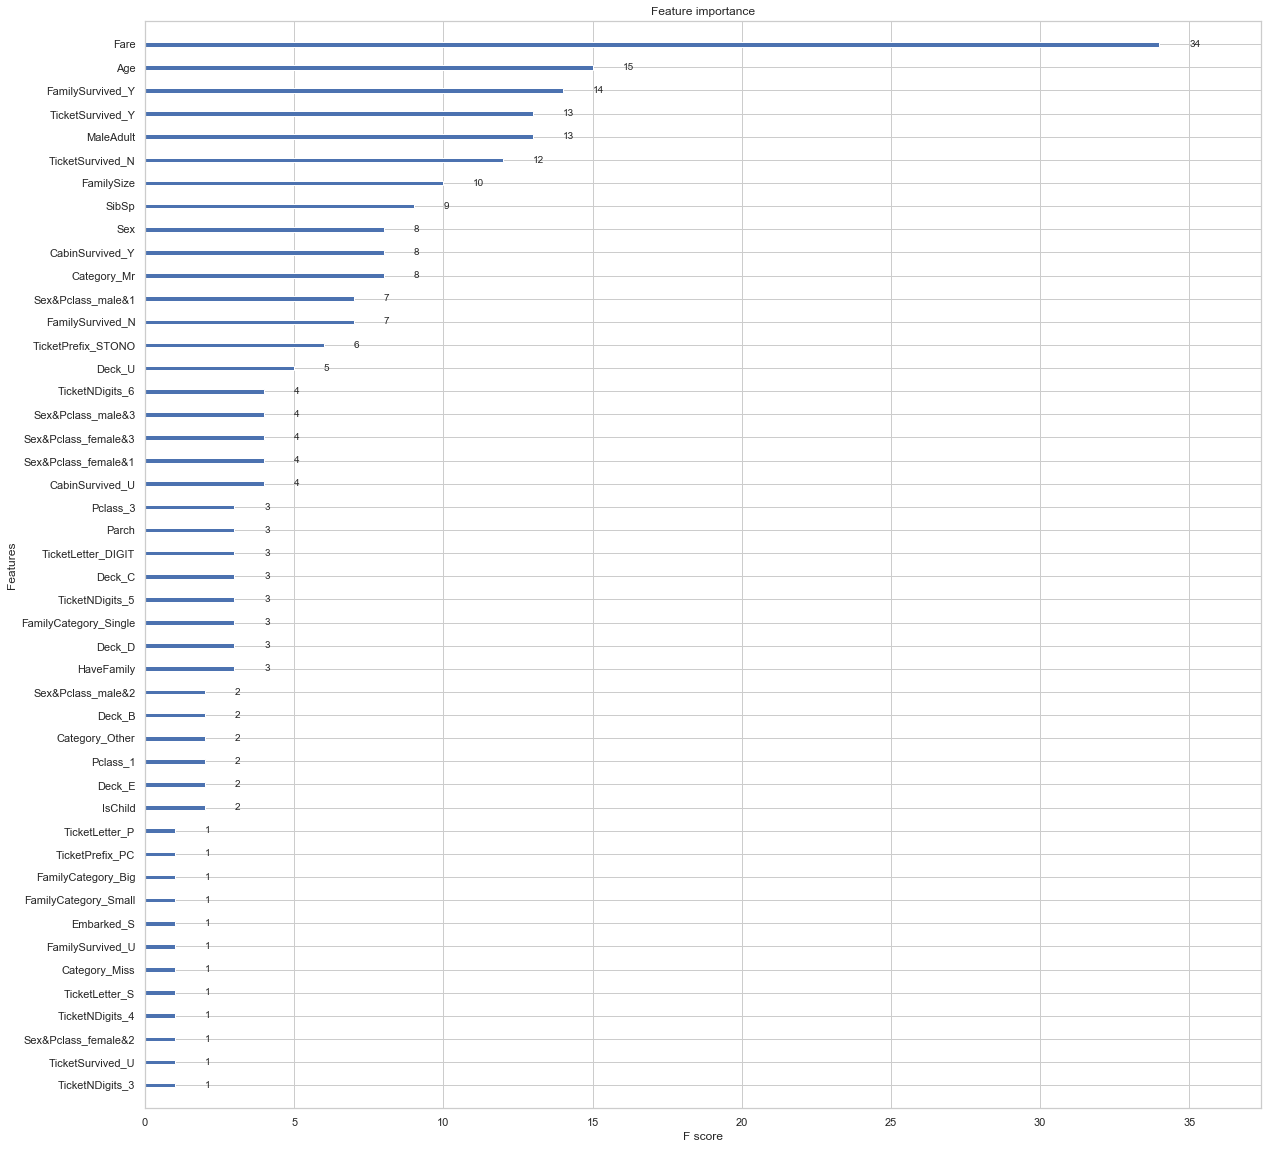

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
xgb.plot_importance(clf, ax=ax)

In [ ]:
test_preds = clf.predict(test_X)
# print(test_preds[:5])
output_predictions(test_preds, test_ids)